# This file combines everything in the project into a single view

# Check that CUDA is available, and import all libraries

In [1]:
import torch
import torchvision
import torch.nn as nn
import os
import yaml
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import MultiStepLR
import math
import os
import math
from functools import partial
from torchvision import transforms
import copy
import matplotlib.pyplot as plt
import yaml
import torch
from tqdm import tqdm

import datasets
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as checkpoint
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
import numpy as np
import os
import time
import shutil
from torch.optim import SGD, Adam
from tensorboardX import SummaryWriter

import json
from PIL import Image

import pickle
import imageio
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import random

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")

PyTorch Version:  1.12.1
Torchvision Version:  0.13.1
Using the GPU!


# Keep track of all models

In [2]:
models = {}


def register(name):
    def decorator(cls):
        models[name] = cls
        return cls
    return decorator


def make(model_spec, args=None, load_sd=False):
    if args is not None:
        model_args = copy.deepcopy(model_spec['args'])
        model_args.update(args)
    else:
        model_args = model_spec['args']
    model = models[model_spec['name']](**model_args)
    if load_sd:
        model.load_state_dict(model_spec['sd'])
    return model


# Encoder

## Common

In [10]:
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size

    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows


def window_reverse(windows, window_size, H, W):
    """
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size
        H (int): Height of image
        W (int): Width of image

    Returns:
        x: (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x

## SwinIR Version (Run this rather than the cell after if you want SwinIR as Encoder)

In [9]:
class WindowAttention(nn.Module):
    r""" Window based multi-head self attention (W-MSA) module with relative position bias.
    It supports both of shifted and non-shifted window.

    Args:
        dim (int): Number of input channels.
        window_size (tuple[int]): The height and width of the window.
        num_heads (int): Number of attention heads.
        qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
        attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
        proj_drop (float, optional): Dropout ratio of output. Default: 0.0
    """

    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):

        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)

        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        """
        Args:
            x: input features with shape of (num_windows*B, N, C)
            mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

    def extra_repr(self) -> str:
        return f'dim={self.dim}, window_size={self.window_size}, num_heads={self.num_heads}'

    def flops(self, N):
        # calculate flops for 1 window with token length of N
        flops = 0
        # qkv = self.qkv(x)
        flops += N * self.dim * 3 * self.dim
        # attn = (q @ k.transpose(-2, -1))
        flops += self.num_heads * N * (self.dim // self.num_heads) * N
        #  x = (attn @ v)
        flops += self.num_heads * N * N * (self.dim // self.num_heads)
        # x = self.proj(x)
        flops += N * self.dim * self.dim
        return flops


class SwinTransformerBlock(nn.Module):
    r""" Swin Transformer Block.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resulotion.
        num_heads (int): Number of attention heads.
        window_size (int): Window size.
        shift_size (int): Shift size for SW-MSA.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            # if window size is larger than input resolution, we don't partition windows
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, window_size=to_2tuple(self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        if self.shift_size > 0:
            attn_mask = self.calculate_mask(self.input_resolution)
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask)

    def calculate_mask(self, x_size):
        # calculate attention mask for SW-MSA
        H, W = x_size
        img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
        h_slices = (slice(0, -self.window_size),
                    slice(-self.window_size, -self.shift_size),
                    slice(-self.shift_size, None))
        w_slices = (slice(0, -self.window_size),
                    slice(-self.window_size, -self.shift_size),
                    slice(-self.shift_size, None))
        cnt = 0
        for h in h_slices:
            for w in w_slices:
                img_mask[:, h, w, :] = cnt
                cnt += 1

        mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
        mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
        attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
        attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))

        return attn_mask

    def forward(self, x, x_size):
        H, W = x_size
        B, L, C = x.shape
        # assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)  # nW*B, window_size*window_size, C

        # W-MSA/SW-MSA (to be compatible for testing on images whose shapes are the multiple of window size
        if self.input_resolution == x_size:
            attn_windows = self.attn(x_windows, mask=self.attn_mask)  # nW*B, window_size*window_size, C
        else:
            attn_windows = self.attn(x_windows, mask=self.calculate_mask(x_size).to(x.device))

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C

        # reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x
        x = x.view(B, H * W, C)

        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, num_heads={self.num_heads}, " \
               f"window_size={self.window_size}, shift_size={self.shift_size}, mlp_ratio={self.mlp_ratio}"

    def flops(self):
        flops = 0
        H, W = self.input_resolution
        # norm1
        flops += self.dim * H * W
        # W-MSA/SW-MSA
        nW = H * W / self.window_size / self.window_size
        flops += nW * self.attn.flops(self.window_size * self.window_size)
        # mlp
        flops += 2 * H * W * self.dim * self.dim * self.mlp_ratio
        # norm2
        flops += self.dim * H * W
        return flops


class PatchMerging(nn.Module):
    r""" Patch Merging Layer.

    Args:
        input_resolution (tuple[int]): Resolution of input feature.
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."

        x = x.view(B, H, W, C)

        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = torch.cat([x0, x1, x2, x3], -1)  # B H/2 W/2 4*C
        x = x.view(B, -1, 4 * C)  # B H/2*W/2 4*C

        x = self.norm(x)
        x = self.reduction(x)

        return x

    def extra_repr(self) -> str:
        return f"input_resolution={self.input_resolution}, dim={self.dim}"

    def flops(self):
        H, W = self.input_resolution
        flops = H * W * self.dim
        flops += (H // 2) * (W // 2) * 4 * self.dim * 2 * self.dim
        return flops


class BasicLayer(nn.Module):
    """ A basic Swin Transformer layer for one stage.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # build blocks
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 drop=drop, attn_drop=attn_drop,
                                 drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                                 norm_layer=norm_layer)
            for i in range(depth)])

        # patch merging layer
        if downsample is not None:
            self.downsample = downsample(input_resolution, dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None

    def forward(self, x, x_size):
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x, x_size)
            else:
                x = blk(x, x_size)
        if self.downsample is not None:
            x = self.downsample(x)
        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, depth={self.depth}"

    def flops(self):
        flops = 0
        for blk in self.blocks:
            flops += blk.flops()
        if self.downsample is not None:
            flops += self.downsample.flops()
        return flops


class RSTB(nn.Module):
    """Residual Swin Transformer Block (RSTB).

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
        img_size: Input image size.
        patch_size: Patch size.
        resi_connection: The convolutional block before residual connection.
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False,
                 img_size=224, patch_size=4, resi_connection='1conv'):
        super(RSTB, self).__init__()

        self.dim = dim
        self.input_resolution = input_resolution

        self.residual_group = BasicLayer(dim=dim,
                                         input_resolution=input_resolution,
                                         depth=depth,
                                         num_heads=num_heads,
                                         window_size=window_size,
                                         mlp_ratio=mlp_ratio,
                                         qkv_bias=qkv_bias, qk_scale=qk_scale,
                                         drop=drop, attn_drop=attn_drop,
                                         drop_path=drop_path,
                                         norm_layer=norm_layer,
                                         downsample=downsample,
                                         use_checkpoint=use_checkpoint)

        if resi_connection == '1conv':
            self.conv = nn.Conv2d(dim, dim, 3, 1, 1)
        elif resi_connection == '3conv':
            # to save parameters and memory
            self.conv = nn.Sequential(nn.Conv2d(dim, dim // 4, 3, 1, 1), nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                      nn.Conv2d(dim // 4, dim // 4, 1, 1, 0),
                                      nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                      nn.Conv2d(dim // 4, dim, 3, 1, 1))

        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=0, embed_dim=dim,
            norm_layer=None)

        self.patch_unembed = PatchUnEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=0, embed_dim=dim,
            norm_layer=None)

    def forward(self, x, x_size):
        return self.patch_embed(self.conv(self.patch_unembed(self.residual_group(x, x_size), x_size))) + x

    def flops(self):
        flops = 0
        flops += self.residual_group.flops()
        H, W = self.input_resolution
        flops += H * W * self.dim * self.dim * 9
        flops += self.patch_embed.flops()
        flops += self.patch_unembed.flops()

        return flops


class PatchEmbed(nn.Module):
    r""" Image to Patch Embedding

    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        x = x.flatten(2).transpose(1, 2)  # B Ph*Pw C
        if self.norm is not None:
            x = self.norm(x)
        return x

    def flops(self):
        flops = 0
        H, W = self.img_size
        if self.norm is not None:
            flops += H * W * self.embed_dim
        return flops


class PatchUnEmbed(nn.Module):
    r""" Image to Patch Unembedding

    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

    def forward(self, x, x_size):
        B, HW, C = x.shape
        x = x.transpose(1, 2).view(B, self.embed_dim, x_size[0], x_size[1])  # B Ph*Pw C
        return x

    def flops(self):
        flops = 0
        return flops


class Upsample(nn.Sequential):
    """Upsample module.

    Args:
        scale (int): Scale factor. Supported scales: 2^n and 3.
        num_feat (int): Channel number of intermediate features.
    """

    def __init__(self, scale, num_feat):
        m = []
        if (scale & (scale - 1)) == 0:  # scale = 2^n
            for _ in range(int(math.log(scale, 2))):
                m.append(nn.Conv2d(num_feat, 4 * num_feat, 3, 1, 1))
                m.append(nn.PixelShuffle(2))
        elif scale == 3:
            m.append(nn.Conv2d(num_feat, 9 * num_feat, 3, 1, 1))
            m.append(nn.PixelShuffle(3))
        else:
            raise ValueError(f'scale {scale} is not supported. ' 'Supported scales: 2^n and 3.')
        super(Upsample, self).__init__(*m)


class UpsampleOneStep(nn.Sequential):
    """UpsampleOneStep module (the difference with Upsample is that it always only has 1conv + 1pixelshuffle)
       Used in lightweight SR to save parameters.

    Args:
        scale (int): Scale factor. Supported scales: 2^n and 3.
        num_feat (int): Channel number of intermediate features.

    """

    def __init__(self, scale, num_feat, num_out_ch, input_resolution=None):
        self.num_feat = num_feat
        self.input_resolution = input_resolution
        m = []
        m.append(nn.Conv2d(num_feat, (scale ** 2) * num_out_ch, 3, 1, 1))
        m.append(nn.PixelShuffle(scale))
        super(UpsampleOneStep, self).__init__(*m)

    def flops(self):
        H, W = self.input_resolution
        flops = H * W * self.num_feat * 3 * 9
        return flops


class SwinIR(nn.Module):
    r""" SwinIR
        A PyTorch impl of : `SwinIR: Image Restoration Using Swin Transformer`, based on Swin Transformer.

    Args:
        img_size (int | tuple(int)): Input image size. Default 64
        patch_size (int | tuple(int)): Patch size. Default: 1
        in_chans (int): Number of input image channels. Default: 3
        embed_dim (int): Patch embedding dimension. Default: 96
        depths (tuple(int)): Depth of each Swin Transformer layer.
        num_heads (tuple(int)): Number of attention heads in different layers.
        window_size (int): Window size. Default: 7
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. Default: 4
        qkv_bias (bool): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float): Override default qk scale of head_dim ** -0.5 if set. Default: None
        drop_rate (float): Dropout rate. Default: 0
        attn_drop_rate (float): Attention dropout rate. Default: 0
        drop_path_rate (float): Stochastic depth rate. Default: 0.1
        norm_layer (nn.Module): Normalization layer. Default: nn.LayerNorm.
        ape (bool): If True, add absolute position embedding to the patch embedding. Default: False
        patch_norm (bool): If True, add normalization after patch embedding. Default: True
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False
        upscale: Upscale factor. 2/3/4/8 for image SR, 1 for denoising and compress artifact reduction
        img_range: Image range. 1. or 255.
        upsampler: The reconstruction reconstruction module. 'pixelshuffle'/'pixelshuffledirect'/'nearest+conv'/None
        resi_connection: The convolutional block before residual connection. '1conv'/'3conv'
    """

    def __init__(self, img_size=48, patch_size=1, in_chans=3,
                #  embed_dim=180, depths=[6, 6, 6, 6, 6, 6], num_heads=[6, 6, 6, 6, 6, 6],              # Trying the full model to see how it fares
                 embed_dim=180, depths=[6, 6, 6], num_heads=[6, 6, 6],            # Making the model smaller                
                 window_size=8, mlp_ratio=2., qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
                 use_checkpoint=False, upscale=2, img_range=1., upsampler='none', resi_connection='1conv',
                 **kwargs):
        super(SwinIR, self).__init__()
        num_in_ch = in_chans
        num_out_ch = in_chans
        num_feat = 64
        self.img_range = img_range
        if in_chans == 3:
            rgb_mean = (0.4488, 0.4371, 0.4040)
            self.mean = torch.Tensor(rgb_mean).view(1, 3, 1, 1)
        else:
            self.mean = torch.zeros(1, 1, 1, 1)
        self.upscale = upscale
        self.upsampler = upsampler
        self.window_size = window_size
        self.out_dim = num_feat
        #####################################################################################################
        ################################### 1, shallow feature extraction ###################################
        self.conv_first = nn.Conv2d(num_in_ch, embed_dim, 3, 1, 1)

        #####################################################################################################
        ################################### 2, deep feature extraction ######################################
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = embed_dim
        self.mlp_ratio = mlp_ratio

        # split image into non-overlapping patches
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=embed_dim, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)
        num_patches = self.patch_embed.num_patches
        patches_resolution = self.patch_embed.patches_resolution
        self.patches_resolution = patches_resolution

        # merge non-overlapping patches into image
        self.patch_unembed = PatchUnEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=embed_dim, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)

        # absolute position embedding
        if self.ape:
            self.absolute_pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
            trunc_normal_(self.absolute_pos_embed, std=.02)

        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule

        # build Residual Swin Transformer blocks (RSTB)
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = RSTB(dim=embed_dim,
                         input_resolution=(patches_resolution[0],
                                           patches_resolution[1]),
                         depth=depths[i_layer],
                         num_heads=num_heads[i_layer],
                         window_size=window_size,
                         mlp_ratio=self.mlp_ratio,
                         qkv_bias=qkv_bias, qk_scale=qk_scale,
                         drop=drop_rate, attn_drop=attn_drop_rate,
                         drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],  # no impact on SR results
                         norm_layer=norm_layer,
                         downsample=None,
                         use_checkpoint=use_checkpoint,
                         img_size=img_size,
                         patch_size=patch_size,
                         resi_connection=resi_connection

                         )
            self.layers.append(layer)
        self.norm = norm_layer(self.num_features)

        # build the last conv layer in deep feature extraction
        if resi_connection == '1conv':
            self.conv_after_body = nn.Conv2d(embed_dim, embed_dim, 3, 1, 1)
        elif resi_connection == '3conv':
            # to save parameters and memory
            self.conv_after_body = nn.Sequential(nn.Conv2d(embed_dim, embed_dim // 4, 3, 1, 1),
                                                 nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                                 nn.Conv2d(embed_dim // 4, embed_dim // 4, 1, 1, 0),
                                                 nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                                 nn.Conv2d(embed_dim // 4, embed_dim, 3, 1, 1))

        #####################################################################################################
        ################################ 3, high quality image reconstruction ################################
        if self.upsampler == 'none':
            self.conv_before_upsample = nn.Sequential(nn.Conv2d(embed_dim, num_feat, 3, 1, 1),
                                                      nn.LeakyReLU(inplace=True))        
        elif self.upsampler == 'pixelshuffle':
            # for classical SR
            self.conv_before_upsample = nn.Sequential(nn.Conv2d(embed_dim, num_feat, 3, 1, 1),
                                                      nn.LeakyReLU(inplace=True))
            self.upsample = Upsample(upscale, num_feat)
            self.conv_last = nn.Conv2d(num_feat, num_out_ch, 3, 1, 1)
        elif self.upsampler == 'pixelshuffledirect':
            # for lightweight SR (to save parameters)
            self.upsample = UpsampleOneStep(upscale, embed_dim, num_out_ch,
                                            (patches_resolution[0], patches_resolution[1]))
        elif self.upsampler == 'nearest+conv':
            # for real-world SR (less artifacts)
            assert self.upscale == 4, 'only support x4 now.'
            self.conv_before_upsample = nn.Sequential(nn.Conv2d(embed_dim, num_feat, 3, 1, 1),
                                                      nn.LeakyReLU(inplace=True))
            self.conv_up1 = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
            self.conv_up2 = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
            self.conv_hr = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
            self.conv_last = nn.Conv2d(num_feat, num_out_ch, 3, 1, 1)
            self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)
        else:
            # for image denoising and JPEG compression artifact reduction
            self.conv_last = nn.Conv2d(embed_dim, num_out_ch, 3, 1, 1)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'absolute_pos_embed'}

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        return {'relative_position_bias_table'}

    def check_image_size(self, x):
        _, _, h, w = x.size()
        mod_pad_h = (self.window_size - h % self.window_size) % self.window_size
        mod_pad_w = (self.window_size - w % self.window_size) % self.window_size
        x = F.pad(x, (0, mod_pad_w, 0, mod_pad_h), 'reflect')
        return x

    def forward_features(self, x):
        x_size = (x.shape[2], x.shape[3])
        x = self.patch_embed(x)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)

        for layer in self.layers:
            x = layer(x, x_size)

        x = self.norm(x)  # B L C
        x = self.patch_unembed(x, x_size)

        return x

    def forward(self, x):
        x = self.check_image_size(x)
        
#         self.mean = self.mean.type_as(x)
#         x = (x - self.mean) * self.img_range
        
        if self.upsampler == 'none':
            x = self.conv_first(x)
            x = self.conv_after_body(self.forward_features(x)) + x
            x = self.conv_before_upsample(x)
        elif self.upsampler == 'pixelshuffle':
            # for classical SR
            x = self.conv_first(x)
            x = self.conv_after_body(self.forward_features(x)) + x
            x = self.conv_before_upsample(x)
            x = self.conv_last(self.upsample(x))
        elif self.upsampler == 'pixelshuffledirect':
            # for lightweight SR
            x = self.conv_first(x)
            x = self.conv_after_body(self.forward_features(x)) + x
            x = self.upsample(x)
        elif self.upsampler == 'nearest+conv':
            # for real-world SR
            x = self.conv_first(x)
            x = self.conv_after_body(self.forward_features(x)) + x
            x = self.conv_before_upsample(x)
            x = self.lrelu(self.conv_up1(torch.nn.functional.interpolate(x, scale_factor=2, mode='nearest')))
            x = self.lrelu(self.conv_up2(torch.nn.functional.interpolate(x, scale_factor=2, mode='nearest')))
            x = self.conv_last(self.lrelu(self.conv_hr(x)))
        else:
            # for image denoising and JPEG compression artifact reduction
            x_first = self.conv_first(x)
            res = self.conv_after_body(self.forward_features(x_first)) + x_first
            x = x + self.conv_last(res)

#         x = x / self.img_range + self.mean

        return x

    def flops(self):
        flops = 0
        H, W = self.patches_resolution
        flops += H * W * 3 * self.embed_dim * 9
        flops += self.patch_embed.flops()
        for i, layer in enumerate(self.layers):
            flops += layer.flops()
        flops += H * W * 3 * self.embed_dim * self.embed_dim
        flops += self.upsample.flops()
        return flops

@register('swinir')
def make_swinir(no_upsampling=True):
    return SwinIR()

## HAT Version (Run this rather than the cell prior if you want HAT as Encoder) Note that names still seems as if it is SwinIR, but it is modified

In [11]:
class WindowAttention(nn.Module):
    r""" Window based multi-head self attention (W-MSA) module with relative position bias.
    It supports both of shifted and non-shifted window.
    Args:
        dim (int): Number of input channels.
        window_size (tuple[int]): The height and width of the window.
        num_heads (int): Number of attention heads.
        qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
        attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
        proj_drop (float, optional): Dropout ratio of output. Default: 0.0
    """

    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):

        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH


        # We should be calculating this separately now, since OCAB is different than HAB. Hence, pass rpi as argument to the forward function
        # # get pair-wise relative position index for each token inside the window
        # coords_h = torch.arange(self.window_size[0])
        # coords_w = torch.arange(self.window_size[1])
        # coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        # coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        # relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        # relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        # relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
        # relative_coords[:, :, 1] += self.window_size[1] - 1
        # relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        # relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        # self.register_buffer("relative_position_index", relative_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)

        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, 
        # The forward function should get the rpi and not use self.relative_position_index.view(-1)
        rpi, 
        mask=None):
        """
        Args:
            x: input features with shape of (num_windows*B, N, C)
            mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        # Changed it so that it is using  the rpi from the argument, as it will be different for OCAB vs HAB
        # relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
        relative_position_bias = self.relative_position_bias_table[rpi.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

    def extra_repr(self) -> str:
        return f'dim={self.dim}, window_size={self.window_size}, num_heads={self.num_heads}'

    def flops(self, N):
        # calculate flops for 1 window with token length of N
        flops = 0
        # qkv = self.qkv(x)
        flops += N * self.dim * 3 * self.dim
        # attn = (q @ k.transpose(-2, -1))
        flops += self.num_heads * N * (self.dim // self.num_heads) * N
        #  x = (attn @ v)
        flops += self.num_heads * N * N * (self.dim // self.num_heads)
        # x = self.proj(x)
        flops += N * self.dim * self.dim
        return flops

# Used by the CAB module
class ChannelAttention(nn.Module):
    """Channel attention used in RCAN.
    Args:
        num_feat (int): Channel number of intermediate features.
        squeeze_factor (int): Channel squeeze factor. Default: 16.
    """

    def __init__(self, num_feat, squeeze_factor=16):
        super(ChannelAttention, self).__init__()
        self.attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(num_feat, num_feat // squeeze_factor, 1, padding=0),
            nn.ReLU(inplace=True),
            nn.Conv2d(num_feat // squeeze_factor, num_feat, 1, padding=0),
            nn.Sigmoid())

    def forward(self, x):
        y = self.attention(x)
        return x * y

# HAT uses a CAB module inside what is the equivalent of the SwinTransformerBlock
class CAB(nn.Module):

    def __init__(self, num_feat, compress_ratio=3, squeeze_factor=30):
        super(CAB, self).__init__()

        self.cab = nn.Sequential(
            nn.Conv2d(num_feat, num_feat // compress_ratio, 3, 1, 1),
            nn.GELU(),
            nn.Conv2d(num_feat // compress_ratio, num_feat, 3, 1, 1),
            ChannelAttention(num_feat, squeeze_factor)
            )

    def forward(self, x):
        return self.cab(x)

class SwinTransformerBlock(nn.Module):
    r""" Swin Transformer Block.
    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resulotion.
        num_heads (int): Number of attention heads.
        window_size (int): Window size.
        shift_size (int): Shift size for SW-MSA.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm,
                 # These arguments are required by the CAB module and the related operations
                 conv_scale=0.01,
                 compress_ratio=3,
                 squeeze_factor=30
                 ):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            # if window size is larger than input resolution, we don't partition windows
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, window_size=to_2tuple(self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        # Initialize the CAB module and the conv scale
        self.conv_scale = conv_scale
        self.conv_block = CAB(num_feat=dim, compress_ratio=compress_ratio, squeeze_factor=squeeze_factor)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        # Don't calculate mask here, take it as an argument
        # if self.shift_size > 0:
        #     attn_mask = self.calculate_mask(self.input_resolution)
        # else:
        #     attn_mask = None

        # self.register_buffer("attn_mask", attn_mask)

    def calculate_mask(self, x_size):
        # calculate attention mask for SW-MSA
        H, W = x_size
        img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
        h_slices = (slice(0, -self.window_size),
                    slice(-self.window_size, -self.shift_size),
                    slice(-self.shift_size, None))
        w_slices = (slice(0, -self.window_size),
                    slice(-self.window_size, -self.shift_size),
                    slice(-self.shift_size, None))
        cnt = 0
        for h in h_slices:
            for w in w_slices:
                img_mask[:, h, w, :] = cnt
                cnt += 1

        mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
        mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
        attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
        attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))

        return attn_mask

    def forward(self, x, x_size,
        # Required now, as they are also used by the forward of HAB
        rpi_sa, attn_mask
    ):
        H, W = x_size
        B, L, C = x.shape
        # assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # Conv_X: Addition from the HAT side that utilizes the CAB mdule
        conv_x = self.conv_block(x.permute(0, 3, 1, 2))
        conv_x = conv_x.permute(0, 2, 3, 1).contiguous().view(B, H * W, C)

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)  # nW*B, window_size*window_size, C

        # W-MSA/SW-MSA (to be compatible for testing on images whose shapes are the multiple of window size
        # if self.input_resolution == x_size:
            # attn_windows = self.attn(x_windows, mask=self.attn_mask)  # nW*B, window_size*window_size, C
        # else:
            # Use the given rpi and the mask
            # attn_windows = self.attn(x_windows, mask=self.calculate_mask(x_size).to(x.device))

        # Use the given rpi and the mask
        attn_windows = self.attn(x_windows, rpi=rpi_sa, mask=attn_mask)  # nW*B, window_size*window_size, C

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C

        # reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x
        x = x.view(B, H * W, C)

        # FFN
        x = shortcut + self.drop_path(x)
        x += conv_x * self.conv_scale                   # This is the contribution from the CAB side as per HAT
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, num_heads={self.num_heads}, " \
               f"window_size={self.window_size}, shift_size={self.shift_size}, mlp_ratio={self.mlp_ratio}"

    def flops(self):
        flops = 0
        H, W = self.input_resolution
        # norm1
        flops += self.dim * H * W
        # W-MSA/SW-MSA
        nW = H * W / self.window_size / self.window_size
        flops += nW * self.attn.flops(self.window_size * self.window_size)
        # mlp
        flops += 2 * H * W * self.dim * self.dim * self.mlp_ratio
        # norm2
        flops += self.dim * H * W
        return flops


class PatchMerging(nn.Module):
    r""" Patch Merging Layer.
    Args:
        input_resolution (tuple[int]): Resolution of input feature.
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."

        x = x.view(B, H, W, C)

        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = torch.cat([x0, x1, x2, x3], -1)  # B H/2 W/2 4*C
        x = x.view(B, -1, 4 * C)  # B H/2*W/2 4*C

        x = self.norm(x)
        x = self.reduction(x)

        return x

    def extra_repr(self) -> str:
        return f"input_resolution={self.input_resolution}, dim={self.dim}"

    def flops(self):
        H, W = self.input_resolution
        flops = H * W * self.dim
        flops += (H // 2) * (W // 2) * 4 * self.dim * 2 * self.dim
        return flops


class BasicLayer(nn.Module):
    """ A basic Swin Transformer layer for one stage.
    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                # The overlap ratio is used by the OCAB block, which comes from the HAT architecture
                 overlap_ratio,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # build blocks
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 drop=drop, attn_drop=attn_drop,
                                 drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                                 norm_layer=norm_layer)
            for i in range(depth)])

        # OCAB: From HAT: STL's have been changed to be equivalent to HAB's, and then we add the OCAB layer to the end
        self.overlap_attn = OCAB(
                            dim=dim,
                            input_resolution=input_resolution,
                            window_size=window_size,
                            overlap_ratio=overlap_ratio,
                            num_heads=num_heads,
                            qkv_bias=qkv_bias,
                            qk_scale=qk_scale,
                            mlp_ratio=mlp_ratio,
                            norm_layer=norm_layer
                            )

        # patch merging layer
        if downsample is not None:
            self.downsample = downsample(input_resolution, dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None

    def forward(self, x, x_size
        # Passing params to get rpi and mask
        , params
        ):
        # The main change is that it will also run the data through OCAB, and also take in the parameters for the rpi and mask
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x, x_size, params['rpi_sa'], params['attn_mask'])
            else:
                x = blk(x, x_size, params['rpi_sa'], params['attn_mask'])

        # Also pass through the OCAB layer
        # x = self.overlap_attn(x, x_size, params['rpi_oca'])
        # We don't have params, but the corresponding value from the dictionary should be self.relative_position_index_OCA in HAT
        #         relative_position_index_OCA = self.calculate_rpi_oca() -> 
        x = self.overlap_attn(x, x_size, params['rpi_oca'])


        if self.downsample is not None:
            x = self.downsample(x)
        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, depth={self.depth}"

    def flops(self):
        flops = 0
        for blk in self.blocks:
            flops += blk.flops()
        if self.downsample is not None:
            flops += self.downsample.flops()
        return flops


class RSTB(nn.Module):
    """Residual Swin Transformer Block (RSTB).
    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
        img_size: Input image size.
        patch_size: Patch size.
        resi_connection: The convolutional block before residual connection.
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 # To be used in the basic layer, which is the equivalent of AttenBlocks
                 overlap_ratio,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False,
                 img_size=224, patch_size=4, resi_connection='1conv'):
        super(RSTB, self).__init__()

        self.dim = dim
        self.input_resolution = input_resolution

        # Basic layer should be transformed into the equivalent of the AttenBlocks over in HAT
        self.residual_group = BasicLayer(dim=dim,
                                         input_resolution=input_resolution,
                                         depth=depth,
                                         num_heads=num_heads,
                                         window_size=window_size,
                                         overlap_ratio=overlap_ratio,   # Getting the argument from parent class arguments, and passing to OCAB
                                         mlp_ratio=mlp_ratio,
                                         qkv_bias=qkv_bias, qk_scale=qk_scale,
                                         drop=drop, attn_drop=attn_drop,
                                         drop_path=drop_path,
                                         norm_layer=norm_layer,
                                         downsample=downsample,
                                         use_checkpoint=use_checkpoint)

        if resi_connection == '1conv':
            self.conv = nn.Conv2d(dim, dim, 3, 1, 1)
        elif resi_connection == '3conv':
            # to save parameters and memory
            self.conv = nn.Sequential(nn.Conv2d(dim, dim // 4, 3, 1, 1), nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                      nn.Conv2d(dim // 4, dim // 4, 1, 1, 0),
                                      nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                      nn.Conv2d(dim // 4, dim, 3, 1, 1))
        # From HAT (RHAG)
        elif resi_connection == 'identity':
            self.conv = nn.Identity()

        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=0, embed_dim=dim,
            norm_layer=None)

        self.patch_unembed = PatchUnEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=0, embed_dim=dim,
            norm_layer=None)

    def forward(self, x, x_size
        # Also take in params
        , params
        ):
        # Pass the params to the residual_group
        return self.patch_embed(self.conv(self.patch_unembed(self.residual_group(x, x_size, params), x_size))) + x

    def flops(self):
        flops = 0
        flops += self.residual_group.flops()
        H, W = self.input_resolution
        flops += H * W * self.dim * self.dim * 9
        flops += self.patch_embed.flops()
        flops += self.patch_unembed.flops()

        return flops


class PatchEmbed(nn.Module):
    r""" Image to Patch Embedding
    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        x = x.flatten(2).transpose(1, 2)  # B Ph*Pw C
        if self.norm is not None:
            x = self.norm(x)
        return x

    def flops(self):
        flops = 0
        H, W = self.img_size
        if self.norm is not None:
            flops += H * W * self.embed_dim
        return flops


class PatchUnEmbed(nn.Module):
    r""" Image to Patch Unembedding
    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

    def forward(self, x, x_size):
        B, HW, C = x.shape
        x = x.transpose(1, 2).view(B, self.embed_dim, x_size[0], x_size[1])  # B Ph*Pw C
        return x

    def flops(self):
        flops = 0
        return flops


class Upsample(nn.Sequential):
    """Upsample module.
    Args:
        scale (int): Scale factor. Supported scales: 2^n and 3.
        num_feat (int): Channel number of intermediate features.
    """

    def __init__(self, scale, num_feat):
        m = []
        if (scale & (scale - 1)) == 0:  # scale = 2^n
            for _ in range(int(math.log(scale, 2))):
                m.append(nn.Conv2d(num_feat, 4 * num_feat, 3, 1, 1))
                m.append(nn.PixelShuffle(2))
        elif scale == 3:
            m.append(nn.Conv2d(num_feat, 9 * num_feat, 3, 1, 1))
            m.append(nn.PixelShuffle(3))
        else:
            raise ValueError(f'scale {scale} is not supported. ' 'Supported scales: 2^n and 3.')
        super(Upsample, self).__init__(*m)


class UpsampleOneStep(nn.Sequential):
    """UpsampleOneStep module (the difference with Upsample is that it always only has 1conv + 1pixelshuffle)
       Used in lightweight SR to save parameters.
    Args:
        scale (int): Scale factor. Supported scales: 2^n and 3.
        num_feat (int): Channel number of intermediate features.
    """

    def __init__(self, scale, num_feat, num_out_ch, input_resolution=None):
        self.num_feat = num_feat
        self.input_resolution = input_resolution
        m = []
        m.append(nn.Conv2d(num_feat, (scale ** 2) * num_out_ch, 3, 1, 1))
        m.append(nn.PixelShuffle(scale))
        super(UpsampleOneStep, self).__init__(*m)

    def flops(self):
        H, W = self.input_resolution
        flops = H * W * self.num_feat * 3 * 9
        return flops


# From the HAT. This goes to the end of the RSTB block, which is the equivalent of the RHAG block over at hat.
class OCAB(nn.Module):
    # overlapping cross-attention block

    def __init__(self, dim,
                input_resolution,
                window_size,
                overlap_ratio,
                num_heads,
                qkv_bias=True,
                qk_scale=None,
                mlp_ratio=2,
                norm_layer=nn.LayerNorm
                ):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.window_size = window_size
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim**-0.5
        self.overlap_win_size = int(window_size * overlap_ratio) + window_size

        self.norm1 = norm_layer(dim)
        self.qkv = nn.Linear(dim, dim * 3,  bias=qkv_bias)
        self.unfold = nn.Unfold(kernel_size=(self.overlap_win_size, self.overlap_win_size), stride=window_size, padding=(self.overlap_win_size-window_size)//2)

        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((window_size + self.overlap_win_size - 1) * (window_size + self.overlap_win_size - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH

        trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

        self.proj = nn.Linear(dim,dim)

        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=nn.GELU)

    def forward(self, x, x_size, rpi):
        h, w = x_size
        b, _, c = x.shape

        shortcut = x
        x = self.norm1(x)
        x = x.view(b, h, w, c)

        qkv = self.qkv(x).reshape(b, h, w, 3, c).permute(3, 0, 4, 1, 2) # 3, b, c, h, w
        q = qkv[0].permute(0, 2, 3, 1) # b, h, w, c
        kv = torch.cat((qkv[1], qkv[2]), dim=1) # b, 2*c, h, w

        # partition windows
        q_windows = window_partition(q, self.window_size)  # nw*b, window_size, window_size, c
        q_windows = q_windows.view(-1, self.window_size * self.window_size, c)  # nw*b, window_size*window_size, c

        kv_windows = self.unfold(kv) # b, c*w*w, nw
        kv_windows = rearrange(kv_windows, 'b (nc ch owh oww) nw -> nc (b nw) (owh oww) ch', nc=2, ch=c, owh=self.overlap_win_size, oww=self.overlap_win_size).contiguous() # 2, nw*b, ow*ow, c
        k_windows, v_windows = kv_windows[0], kv_windows[1] # nw*b, ow*ow, c

        b_, nq, _ = q_windows.shape
        _, n, _ = k_windows.shape
        d = self.dim // self.num_heads
        q = q_windows.reshape(b_, nq, self.num_heads, d).permute(0, 2, 1, 3) # nw*b, nH, nq, d
        k = k_windows.reshape(b_, n, self.num_heads, d).permute(0, 2, 1, 3) # nw*b, nH, n, d
        v = v_windows.reshape(b_, n, self.num_heads, d).permute(0, 2, 1, 3) # nw*b, nH, n, d

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        relative_position_bias = self.relative_position_bias_table[rpi.view(-1)].view(
            self.window_size * self.window_size, self.overlap_win_size * self.overlap_win_size, -1)  # ws*ws, wse*wse, nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, ws*ws, wse*wse
        attn = attn + relative_position_bias.unsqueeze(0)

        attn = self.softmax(attn)
        attn_windows = (attn @ v).transpose(1, 2).reshape(b_, nq, self.dim)

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, self.dim)
        x = window_reverse(attn_windows, self.window_size, h, w)  # b h w c
        x = x.view(b, h * w, self.dim)

        x = self.proj(x) + shortcut

        x = x + self.mlp(self.norm2(x))
        return x

class SwinIR(nn.Module):
    r""" SwinIR
        A PyTorch impl of : `SwinIR: Image Restoration Using Swin Transformer`, based on Swin Transformer.
    Args:
        img_size (int | tuple(int)): Input image size. Default 64
        patch_size (int | tuple(int)): Patch size. Default: 1
        in_chans (int): Number of input image channels. Default: 3
        embed_dim (int): Patch embedding dimension. Default: 96
        depths (tuple(int)): Depth of each Swin Transformer layer.
        num_heads (tuple(int)): Number of attention heads in different layers.
        window_size (int): Window size. Default: 7
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. Default: 4
        qkv_bias (bool): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float): Override default qk scale of head_dim ** -0.5 if set. Default: None
        drop_rate (float): Dropout rate. Default: 0
        attn_drop_rate (float): Attention dropout rate. Default: 0
        drop_path_rate (float): Stochastic depth rate. Default: 0.1
        norm_layer (nn.Module): Normalization layer. Default: nn.LayerNorm.
        ape (bool): If True, add absolute position embedding to the patch embedding. Default: False
        patch_norm (bool): If True, add normalization after patch embedding. Default: True
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False
        upscale: Upscale factor. 2/3/4/8 for image SR, 1 for denoising and compress artifact reduction
        img_range: Image range. 1. or 255.
        upsampler: The reconstruction reconstruction module. 'pixelshuffle'/'pixelshuffledirect'/'nearest+conv'/None
        resi_connection: The convolutional block before residual connection. '1conv'/'3conv'
    """

    def __init__(self, img_size=48, patch_size=1, in_chans=3,
                # Adding overlap_ratio for the OCAB block, and changing the size of the model to be smaller
                #  embed_dim=180, depths=[6, 6, 6, 6, 6, 6], num_heads=[6, 6, 6, 6, 6, 6], overlap_ratio=0.5,             # Trying the full model to see how it fares
                 embed_dim=180, depths=[6, 6, 6], num_heads=[6, 6, 6], overlap_ratio=0.5,                                 # Making the model smaller
                 window_size=8, mlp_ratio=2., qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
                 use_checkpoint=False, upscale=2, img_range=1., upsampler='none', resi_connection='1conv',
                 **kwargs):
        super(SwinIR, self).__init__()
        num_in_ch = in_chans
        num_out_ch = in_chans
        num_feat = 64
        self.img_range = img_range
        if in_chans == 3:
            rgb_mean = (0.4488, 0.4371, 0.4040)
            self.mean = torch.Tensor(rgb_mean).view(1, 3, 1, 1)
        else:
            self.mean = torch.zeros(1, 1, 1, 1)
        self.upscale = upscale
        self.upsampler = upsampler
        self.window_size = window_size
        self.out_dim = num_feat

        # Need these here so that rpi calculation can use them
        self.shift_size = window_size // 2
        self.overlap_ratio = overlap_ratio
        # From HAT: we calculate the rpi's over here, which will be passed inside the params dictionary given to the forward function
        relative_position_index_SA = self.calculate_rpi_sa()
        relative_position_index_OCA = self.calculate_rpi_oca()
        self.register_buffer('relative_position_index_SA', relative_position_index_SA)
        self.register_buffer('relative_position_index_OCA', relative_position_index_OCA)

        #####################################################################################################
        ################################### 1, shallow feature extraction ###################################
        self.conv_first = nn.Conv2d(num_in_ch, embed_dim, 3, 1, 1)

        #####################################################################################################
        ################################### 2, deep feature extraction ######################################
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = embed_dim
        self.mlp_ratio = mlp_ratio

        # split image into non-overlapping patches
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=embed_dim, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)
        num_patches = self.patch_embed.num_patches
        patches_resolution = self.patch_embed.patches_resolution
        self.patches_resolution = patches_resolution

        # merge non-overlapping patches into image
        self.patch_unembed = PatchUnEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=embed_dim, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)

        # absolute position embedding
        if self.ape:
            self.absolute_pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
            trunc_normal_(self.absolute_pos_embed, std=.02)

        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule

        # build Residual Swin Transformer blocks (RSTB)
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = RSTB(dim=embed_dim,
                         input_resolution=(patches_resolution[0],
                                           patches_resolution[1]),
                         depth=depths[i_layer],
                         num_heads=num_heads[i_layer],
                         window_size=window_size,
                         # From the HAT side, we use the overlap ratio inside OCAB stuff``
                         overlap_ratio=overlap_ratio,
                         mlp_ratio=self.mlp_ratio,
                         qkv_bias=qkv_bias, qk_scale=qk_scale,
                         drop=drop_rate, attn_drop=attn_drop_rate,
                         drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],  # no impact on SR results
                         norm_layer=norm_layer,
                         downsample=None,
                         use_checkpoint=use_checkpoint,
                         img_size=img_size,
                         patch_size=patch_size,
                         resi_connection=resi_connection

                         )
            self.layers.append(layer)
        self.norm = norm_layer(self.num_features)

        # build the last conv layer in deep feature extraction
        if resi_connection == '1conv':
            self.conv_after_body = nn.Conv2d(embed_dim, embed_dim, 3, 1, 1)
        elif resi_connection == '3conv':
            # to save parameters and memory
            self.conv_after_body = nn.Sequential(nn.Conv2d(embed_dim, embed_dim // 4, 3, 1, 1),
                                                 nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                                 nn.Conv2d(embed_dim // 4, embed_dim // 4, 1, 1, 0),
                                                 nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                                 nn.Conv2d(embed_dim // 4, embed_dim, 3, 1, 1))

        #####################################################################################################
        ################################ 3, high quality image reconstruction ################################
        if self.upsampler == 'none':
            self.conv_before_upsample = nn.Sequential(nn.Conv2d(embed_dim, num_feat, 3, 1, 1),
                                                      nn.LeakyReLU(inplace=True))        
        elif self.upsampler == 'pixelshuffle':
            # for classical SR
            self.conv_before_upsample = nn.Sequential(nn.Conv2d(embed_dim, num_feat, 3, 1, 1),
                                                      nn.LeakyReLU(inplace=True))
            self.upsample = Upsample(upscale, num_feat)
            self.conv_last = nn.Conv2d(num_feat, num_out_ch, 3, 1, 1)
        elif self.upsampler == 'pixelshuffledirect':
            # for lightweight SR (to save parameters)
            self.upsample = UpsampleOneStep(upscale, embed_dim, num_out_ch,
                                            (patches_resolution[0], patches_resolution[1]))
        elif self.upsampler == 'nearest+conv':
            # for real-world SR (less artifacts)
            assert self.upscale == 4, 'only support x4 now.'
            self.conv_before_upsample = nn.Sequential(nn.Conv2d(embed_dim, num_feat, 3, 1, 1),
                                                      nn.LeakyReLU(inplace=True))
            self.conv_up1 = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
            self.conv_up2 = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
            self.conv_hr = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
            self.conv_last = nn.Conv2d(num_feat, num_out_ch, 3, 1, 1)
            self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)
        else:
            # for image denoising and JPEG compression artifact reduction
            self.conv_last = nn.Conv2d(embed_dim, num_out_ch, 3, 1, 1)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'absolute_pos_embed'}

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        return {'relative_position_bias_table'}

    def check_image_size(self, x):
        _, _, h, w = x.size()
        mod_pad_h = (self.window_size - h % self.window_size) % self.window_size
        mod_pad_w = (self.window_size - w % self.window_size) % self.window_size
        x = F.pad(x, (0, mod_pad_w, 0, mod_pad_h), 'reflect')
        return x

    # These three functions are from HAT, and they are moved here because we calculate different rpi and mask depending on whether we are using HAB or OCAB
    def calculate_rpi_sa(self):
        # calculate relative position index for SA
        coords_h = torch.arange(self.window_size)
        coords_w = torch.arange(self.window_size)
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.window_size - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size - 1
        relative_coords[:, :, 0] *= 2 * self.window_size - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        return relative_position_index

    def calculate_rpi_oca(self):
        # calculate relative position index for OCA
        window_size_ori = self.window_size
        window_size_ext = self.window_size + int(self.overlap_ratio * self.window_size)

        coords_h = torch.arange(window_size_ori)
        coords_w = torch.arange(window_size_ori)
        coords_ori = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, ws, ws
        coords_ori_flatten = torch.flatten(coords_ori, 1)  # 2, ws*ws

        coords_h = torch.arange(window_size_ext)
        coords_w = torch.arange(window_size_ext)
        coords_ext = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, wse, wse
        coords_ext_flatten = torch.flatten(coords_ext, 1)  # 2, wse*wse

        relative_coords = coords_ext_flatten[:, None, :] - coords_ori_flatten[:, :, None]   # 2, ws*ws, wse*wse

        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # ws*ws, wse*wse, 2
        relative_coords[:, :, 0] += window_size_ori - window_size_ext + 1  # shift to start from 0
        relative_coords[:, :, 1] += window_size_ori - window_size_ext + 1

        relative_coords[:, :, 0] *= window_size_ori + window_size_ext - 1
        relative_position_index = relative_coords.sum(-1)
        return relative_position_index

    def calculate_mask(self, x_size):
        # calculate attention mask for SW-MSA
        h, w = x_size
        img_mask = torch.zeros((1, h, w, 1))  # 1 h w 1
        h_slices = (slice(0, -self.window_size), slice(-self.window_size,
                                                       -self.shift_size), slice(-self.shift_size, None))
        w_slices = (slice(0, -self.window_size), slice(-self.window_size,
                                                       -self.shift_size), slice(-self.shift_size, None))
        cnt = 0
        for h in h_slices:
            for w in w_slices:
                img_mask[:, h, w, :] = cnt
                cnt += 1

        mask_windows = window_partition(img_mask, self.window_size)  # nw, window_size, window_size, 1
        mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
        attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
        attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))

        return attn_mask

    def forward_features(self, x):
        x_size = (x.shape[2], x.shape[3])

        # Added from the HAT class
        # Calculate attention mask and relative position index in advance to speed up inference. 
        # The original code is very time-cosuming for large window size.
        attn_mask = self.calculate_mask(x_size).to(x.device)
        params = {'attn_mask': attn_mask, 'rpi_sa': self.relative_position_index_SA, 'rpi_oca': self.relative_position_index_OCA}


        x = self.patch_embed(x)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)

        for layer in self.layers:
            # We are passing params now
            x = layer(x, x_size, params)

        x = self.norm(x)  # B L C
        x = self.patch_unembed(x, x_size)

        return x

    def forward(self, x):
        x = self.check_image_size(x)
        
#         self.mean = self.mean.type_as(x)
#         x = (x - self.mean) * self.img_range
        
        if self.upsampler == 'none':
            x = self.conv_first(x)
            x = self.conv_after_body(self.forward_features(x)) + x
            x = self.conv_before_upsample(x)
        elif self.upsampler == 'pixelshuffle':
            # for classical SR
            x = self.conv_first(x)
            x = self.conv_after_body(self.forward_features(x)) + x
            x = self.conv_before_upsample(x)
            x = self.conv_last(self.upsample(x))
        elif self.upsampler == 'pixelshuffledirect':
            # for lightweight SR
            x = self.conv_first(x)
            x = self.conv_after_body(self.forward_features(x)) + x
            x = self.upsample(x)
        elif self.upsampler == 'nearest+conv':
            # for real-world SR
            x = self.conv_first(x)
            x = self.conv_after_body(self.forward_features(x)) + x
            x = self.conv_before_upsample(x)
            x = self.lrelu(self.conv_up1(torch.nn.functional.interpolate(x, scale_factor=2, mode='nearest')))
            x = self.lrelu(self.conv_up2(torch.nn.functional.interpolate(x, scale_factor=2, mode='nearest')))
            x = self.conv_last(self.lrelu(self.conv_hr(x)))
        else:
            # for image denoising and JPEG compression artifact reduction
            x_first = self.conv_first(x)
            res = self.conv_after_body(self.forward_features(x_first)) + x_first
            x = x + self.conv_last(res)

#         x = x / self.img_range + self.mean

        return x

    def flops(self):
        flops = 0
        H, W = self.patches_resolution
        flops += H * W * 3 * self.embed_dim * 9
        flops += self.patch_embed.flops()
        for i, layer in enumerate(self.layers):
            flops += layer.flops()
        flops += H * W * 3 * self.embed_dim * self.embed_dim
        flops += self.upsample.flops()
        return flops

@register('swinir')
def make_swinir(no_upsampling=True):
    return SwinIR()

# LTE

In [4]:
@register('lte')
class LTE(nn.Module):

    def __init__(self, encoder_spec, imnet_spec=None, hidden_dim=256):
        super().__init__()        
        self.encoder = make(encoder_spec)
        self.coef = nn.Conv2d(self.encoder.out_dim, hidden_dim, 3, padding=1)
        self.freq = nn.Conv2d(self.encoder.out_dim, hidden_dim, 3, padding=1)
        self.phase = nn.Linear(2, hidden_dim//2, bias=False)        

        self.imnet = make(imnet_spec, args={'in_dim': hidden_dim})

    def gen_feat(self, inp):
        self.inp = inp
        self.feat_coord = make_coord(inp.shape[-2:], flatten=False).cuda() \
            .permute(2, 0, 1) \
            .unsqueeze(0).expand(inp.shape[0], 2, *inp.shape[-2:])
        
        self.feat = self.encoder(inp)
        self.coeff = self.coef(self.feat)
        self.freqq = self.freq(self.feat)
        return self.feat

    def query_rgb(self, coord, cell=None):
        feat = self.feat
        coef = self.coeff
        freq = self.freqq

        vx_lst = [-1, 1]
        vy_lst = [-1, 1]
        eps_shift = 1e-6 

        # field radius (global: [-1, 1])
        rx = 2 / feat.shape[-2] / 2
        ry = 2 / feat.shape[-1] / 2

        feat_coord = self.feat_coord

        preds = []
        areas = []
        for vx in vx_lst:
            for vy in vy_lst:
                # prepare coefficient & frequency
                coord_ = coord.clone()
                coord_[:, :, 0] += vx * rx + eps_shift
                coord_[:, :, 1] += vy * ry + eps_shift
                coord_.clamp_(-1 + 1e-6, 1 - 1e-6)
                q_coef = F.grid_sample(
                    coef, coord_.flip(-1).unsqueeze(1),
                    mode='nearest', align_corners=False)[:, :, 0, :] \
                    .permute(0, 2, 1)
                q_freq = F.grid_sample(
                    freq, coord_.flip(-1).unsqueeze(1),
                    mode='nearest', align_corners=False)[:, :, 0, :] \
                    .permute(0, 2, 1)
                q_coord = F.grid_sample(
                    feat_coord, coord_.flip(-1).unsqueeze(1),
                    mode='nearest', align_corners=False)[:, :, 0, :] \
                    .permute(0, 2, 1)
                rel_coord = coord - q_coord
                rel_coord[:, :, 0] *= feat.shape[-2]
                rel_coord[:, :, 1] *= feat.shape[-1]
                
                # prepare cell
                rel_cell = cell.clone()
                rel_cell[:, :, 0] *= feat.shape[-2]
                rel_cell[:, :, 1] *= feat.shape[-1]
                
                # basis generation
                bs, q = coord.shape[:2]
                q_freq = torch.stack(torch.split(q_freq, 2, dim=-1), dim=-1)
                q_freq = torch.mul(q_freq, rel_coord.unsqueeze(-1))
                q_freq = torch.sum(q_freq, dim=-2)
                q_freq += self.phase(rel_cell.view((bs * q, -1))).view(bs, q, -1)
                q_freq = torch.cat((torch.cos(np.pi*q_freq), torch.sin(np.pi*q_freq)), dim=-1)

                inp = torch.mul(q_coef, q_freq)            

                pred = self.imnet(inp.contiguous().view(bs * q, -1)).view(bs, q, -1)
                preds.append(pred)

                area = torch.abs(rel_coord[:, :, 0] * rel_coord[:, :, 1])
                areas.append(area + 1e-9)

        tot_area = torch.stack(areas).sum(dim=0)
        t = areas[0]; areas[0] = areas[3]; areas[3] = t
        t = areas[1]; areas[1] = areas[2]; areas[2] = t
        
        ret = 0
        for pred, area in zip(preds, areas):
            ret = ret + pred * (area / tot_area).unsqueeze(-1)
        ret += F.grid_sample(self.inp, coord.flip(-1).unsqueeze(1), mode='bilinear',\
                      padding_mode='border', align_corners=False)[:, :, 0, :] \
                      .permute(0, 2, 1)
        return ret

    def forward(self, inp, coord, cell):
        self.gen_feat(inp)
        return self.query_rgb(coord, cell)

# Decoder

In [5]:
@register('mlp')
class MLP(nn.Module):

    def __init__(self, in_dim, out_dim, hidden_list):
        super().__init__()
        layers = []
        lastv = in_dim
        for hidden in hidden_list:
            layers.append(nn.Linear(lastv, hidden))
            layers.append(nn.ReLU())
            lastv = hidden
        layers.append(nn.Linear(lastv, out_dim))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        shape = x.shape[:-1]
        x = self.layers(x.view(-1, x.shape[-1]))
        return x.view(*shape, -1)

# Utility functions

In [6]:
class Averager():

    def __init__(self):
        self.n = 0.0
        self.v = 0.0

    def add(self, v, n=1.0):
        self.v = (self.v * self.n + v * n) / (self.n + n)
        self.n += n

    def item(self):
        return self.v


class Timer():

    def __init__(self):
        self.v = time.time()

    def s(self):
        self.v = time.time()

    def t(self):
        return time.time() - self.v


def time_text(t):
    if t >= 3600:
        return '{:.1f}h'.format(t / 3600)
    elif t >= 60:
        return '{:.1f}m'.format(t / 60)
    else:
        return '{:.1f}s'.format(t)


_log_path = None


def set_log_path(path):
    global _log_path
    _log_path = path


def log(obj, filename='log.txt'):
    print(obj)
    if _log_path is not None:
        with open(os.path.join(_log_path, filename), 'a') as f:
            print(obj, file=f)


def ensure_path(path, remove=True):
    basename = os.path.basename(path.rstrip('/'))
    if os.path.exists(path):
        if remove and (basename.startswith('_')
                or input('{} exists, remove? (y/[n]): '.format(path)) == 'y'):
            shutil.rmtree(path)
            os.makedirs(path)
    else:
        os.makedirs(path)


def set_save_path(save_path, remove=True):
    ensure_path(save_path, remove=remove)
    set_log_path(save_path)
    writer = SummaryWriter(os.path.join(save_path, 'tensorboard'))
    return log, writer


def compute_num_params(model, text=False):
    tot = int(sum([np.prod(p.shape) for p in model.parameters()]))
    if text:
        if tot >= 1e6:
            return '{:.1f}M'.format(tot / 1e6)
        else:
            return '{:.1f}K'.format(tot / 1e3)
    else:
        return tot


def make_optimizer(param_list, optimizer_spec, load_sd=False):
    Optimizer = {
        'sgd': SGD,
        'adam': Adam
    }[optimizer_spec['name']]
    optimizer = Optimizer(param_list, **optimizer_spec['args'])
    if load_sd:
        optimizer.load_state_dict(optimizer_spec['sd'])
    return optimizer


def make_coord(shape, ranges=None, flatten=True):
    """ Make coordinates at grid centers.
    """
    coord_seqs = []
    for i, n in enumerate(shape):
        if ranges is None:
            v0, v1 = -1, 1
        else:
            v0, v1 = ranges[i]
        r = (v1 - v0) / (2 * n)
        seq = v0 + r + (2 * r) * torch.arange(n).float()
        coord_seqs.append(seq)
    ret = torch.stack(torch.meshgrid(*coord_seqs), dim=-1)
    if flatten:
        ret = ret.view(-1, ret.shape[-1])
    return ret


def to_pixel_samples(img):
    """ Convert the image to coord-RGB pairs.
        img: Tensor, (3, H, W)
    """
    coord = make_coord(img.shape[-2:])
    rgb = img.view(3, -1).permute(1, 0)
    return coord, rgb


def calc_psnr(sr, hr, dataset=None, scale=1, rgb_range=1):
    diff = (sr - hr) / rgb_range
    if dataset is not None:
        if dataset == 'benchmark':
            shave = scale
            if diff.size(1) > 1:
                gray_coeffs = [65.738, 129.057, 25.064]
                convert = diff.new_tensor(gray_coeffs).view(1, 3, 1, 1) / 256
                diff = diff.mul(convert).sum(dim=1)
        elif dataset == 'div2k':
            shave = scale + 6
        else:
            raise NotImplementedError
        valid = diff[..., shave:-shave, shave:-shave]
    else:
        valid = diff
    mse = valid.pow(2).mean()
    return -10 * torch.log10(mse)


def batched_predict(model, inp, coord, cell, bsize):
    with torch.no_grad():
        model.gen_feat(inp)
        n = coord.shape[1]
        ql = 0
        preds = []
        while ql < n:
            qr = min(ql + bsize, n)
            pred = model.query_rgb(coord[:, ql: qr, :], cell[:, ql: qr, :])
            preds.append(pred)
            ql = qr
        pred = torch.cat(preds, dim=1)
    return pred


def eval_psnr(loader, model, data_norm=None, eval_type=None, eval_bsize=None, window_size=0, scale_max=4, fast=False,
              verbose=False):
    model.eval()

    if data_norm is None:
        data_norm = {
            'inp': {'sub': [0], 'div': [1]},
            'gt': {'sub': [0], 'div': [1]}
        }
    t = data_norm['inp']
    inp_sub = torch.FloatTensor(t['sub']).view(1, -1, 1, 1).cuda()
    inp_div = torch.FloatTensor(t['div']).view(1, -1, 1, 1).cuda()
    t = data_norm['gt']
    gt_sub = torch.FloatTensor(t['sub']).view(1, 1, -1).cuda()
    gt_div = torch.FloatTensor(t['div']).view(1, 1, -1).cuda()

    if eval_type is None:
        metric_fn = calc_psnr
    elif eval_type.startswith('div2k'):
        scale = int(eval_type.split('-')[1])
        metric_fn = partial(calc_psnr, dataset='div2k', scale=scale)
    elif eval_type.startswith('benchmark'):
        scale = int(eval_type.split('-')[1])
        metric_fn = partial(calc_psnr, dataset='benchmark', scale=scale)
    else:
        raise NotImplementedError

    val_res = Averager()

    pbar = tqdm(loader, leave=False, desc='val')
    for batch in pbar:
        for k, v in batch.items():
            batch[k] = v.cuda()

        inp = (batch['inp'] - inp_sub) / inp_div
        # SwinIR Evaluation - reflection padding
        if window_size != 0:
            _, _, h_old, w_old = inp.size()
            h_pad = (h_old // window_size + 1) * window_size - h_old
            w_pad = (w_old // window_size + 1) * window_size - w_old
            inp = torch.cat([inp, torch.flip(inp, [2])], 2)[:, :, :h_old + h_pad, :]
            inp = torch.cat([inp, torch.flip(inp, [3])], 3)[:, :, :, :w_old + w_pad]
            
            coord = make_coord((scale*(h_old+h_pad), scale*(w_old+w_pad))).unsqueeze(0).cuda()
            cell = torch.ones_like(coord)
            cell[:, :, 0] *= 2 / inp.shape[-2] / scale
            cell[:, :, 1] *= 2 / inp.shape[-1] / scale
        else:
            h_pad = 0
            w_pad = 0
            
            coord = batch['coord']
            cell = batch['cell']
            
        if eval_bsize is None:
            with torch.no_grad():
                pred = model(inp, coord, cell)
        else:
            if fast:
                pred = model(inp, coord, cell*max(scale/scale_max, 1))
            else:
                pred = batched_predict(model, inp, coord, cell*max(scale/scale_max, 1), eval_bsize) # cell clip for extrapolation
            
        pred = pred * gt_div + gt_sub
        pred.clamp_(0, 1)

        if eval_type is not None and fast == False: # reshape for shaving-eval
            # gt reshape
            ih, iw = batch['inp'].shape[-2:]
            s = math.sqrt(batch['coord'].shape[1] / (ih * iw))
            shape = [batch['inp'].shape[0], round(ih * s), round(iw * s), 3]
            batch['gt'] = batch['gt'].view(*shape) \
                .permute(0, 3, 1, 2).contiguous()
            
            # prediction reshape
            ih += h_pad
            iw += w_pad
            s = math.sqrt(coord.shape[1] / (ih * iw))
            shape = [batch['inp'].shape[0], round(ih * s), round(iw * s), 3]
            pred = pred.view(*shape) \
                .permute(0, 3, 1, 2).contiguous()
            pred = pred[..., :batch['gt'].shape[-2], :batch['gt'].shape[-1]]
            
        res = metric_fn(pred, batch['gt'])
        val_res.add(res.item(), inp.shape[0])

        if verbose:
            pbar.set_description('val {:.4f}'.format(val_res.item()))
            
    return val_res.item()

# Training

In [56]:
def make_data_loader(spec, tag=''):
    if spec is None:
        return None

    dataset = datasets.make(spec['dataset'])
    dataset = datasets.make(spec['wrapper'], args={'dataset': dataset})

    log('{} dataset: size={}'.format(tag, len(dataset)))
    for k, v in dataset[0].items():
        log('  {}: shape={}'.format(k, tuple(v.shape)))

    loader = DataLoader(dataset, batch_size=spec['batch_size'],
        shuffle=(tag == 'train'), num_workers=1, pin_memory=True)   # Changed number of workers since ram was not enough
    return loader


def make_data_loaders():
    train_loader = make_data_loader(config.get('train_dataset'), tag='train')
    val_loader = make_data_loader(config.get('val_dataset'), tag='val')
    return train_loader, val_loader


def prepare_training():
#     if config.get('resume') is not None:
    if os.path.exists(config.get('resume')):
        sv_file = torch.load(config['resume'])
        model = make(sv_file['model'], load_sd=True).cuda()
        optimizer = make_optimizer(
            model.parameters(), sv_file['optimizer'], load_sd=True)
        epoch_start = sv_file['epoch'] + 1
        if config.get('multi_step_lr') is None:
            lr_scheduler = None
        else:
            lr_scheduler = MultiStepLR(optimizer, **config['multi_step_lr'])
        for _ in range(epoch_start - 1):
            lr_scheduler.step()
    else:
        model = make(config['model']).cuda()
        optimizer = make_optimizer(
            model.parameters(), config['optimizer'])
        epoch_start = 1
        if config.get('multi_step_lr') is None:
            lr_scheduler = None
        else:
            lr_scheduler = MultiStepLR(optimizer, **config['multi_step_lr'])

    log('model: #params={}'.format(compute_num_params(model, text=True)))
    return model, optimizer, epoch_start, lr_scheduler


def tmp_train(train_loader, model, optimizer, \
         epoch):
    model.train()
    loss_fn = nn.L1Loss()
    train_loss = Averager()
    metric_fn = calc_psnr

    data_norm = config['data_norm']
    t = data_norm['inp']
    inp_sub = torch.FloatTensor(t['sub']).view(1, -1, 1, 1).cuda()
    inp_div = torch.FloatTensor(t['div']).view(1, -1, 1, 1).cuda()
    t = data_norm['gt']
    gt_sub = torch.FloatTensor(t['sub']).view(1, 1, -1).cuda()
    gt_div = torch.FloatTensor(t['div']).view(1, 1, -1).cuda()
    
    num_dataset = 800 # DIV2K
    iter_per_epoch = int(num_dataset / config.get('train_dataset')['batch_size'] \
                        * config.get('train_dataset')['dataset']['args']['repeat'])
    iteration = 0
    for batch in tqdm(train_loader, leave=False, desc='train'):
        for k, v in batch.items():
            batch[k] = v.cuda()

        inp = (batch['inp'] - inp_sub) / inp_div
        pred = model(inp, batch['coord'], batch['cell'])

        gt = (batch['gt'] - gt_sub) / gt_div
        loss = loss_fn(pred, gt)
        psnr = metric_fn(pred, gt)
        
        # tensorboard
        writer.add_scalars('loss', {'train': loss.item()}, (epoch-1)*iter_per_epoch + iteration)
        writer.add_scalars('psnr', {'train': psnr}, (epoch-1)*iter_per_epoch + iteration)
        iteration += 1

        train_loss.add(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred = None; loss = None
        
    return train_loss.item()


def main(config_, save_path):
    global config, log, writer
    config = config_
    log, writer = set_save_path(save_path, remove=False)
    with open(os.path.join(save_path, 'config.yaml'), 'w') as f:
        yaml.dump(config, f, sort_keys=False)

    train_loader, val_loader = make_data_loaders()
    if config.get('data_norm') is None:
        config['data_norm'] = {
            'inp': {'sub': [0], 'div': [1]},
            'gt': {'sub': [0], 'div': [1]}
        }

    model, optimizer, epoch_start, lr_scheduler = prepare_training()

    n_gpus = len(os.environ['CUDA_VISIBLE_DEVICES'].split(','))
    if n_gpus > 1:
        model = nn.parallel.DataParallel(model)

    epoch_max = config['epoch_max']
    epoch_val = config.get('epoch_val')
    epoch_save = config.get('epoch_save')
    max_val_v = -1e18

    timer = Timer()

    for epoch in range(epoch_start, epoch_max + 1):
        t_epoch_start = timer.t()
        log_info = ['epoch {}/{}'.format(epoch, epoch_max)]

        writer.add_scalar('lr', optimizer.param_groups[0]['lr'], epoch)

        train_loss = tmp_train(train_loader, model, optimizer, \
                           epoch)
        if lr_scheduler is not None:
            lr_scheduler.step()

        log_info.append('train: loss={:.4f}'.format(train_loss))
#         writer.add_scalars('loss', {'train': train_loss}, epoch)

        if n_gpus > 1:
            model_ = model.module
        else:
            model_ = model
        model_spec = config['model']
        model_spec['sd'] = model_.state_dict()
        optimizer_spec = config['optimizer']
        optimizer_spec['sd'] = optimizer.state_dict()
        sv_file = {
            'model': model_spec,
            'optimizer': optimizer_spec,
            'epoch': epoch
        }

        torch.save(sv_file, os.path.join(save_path, 'epoch-last.pth'))

        if (epoch_save is not None) and (epoch % epoch_save == 0):
            torch.save(sv_file,
                os.path.join(save_path, 'epoch-{}.pth'.format(epoch)))

        if (epoch_val is not None) and (epoch % epoch_val == 0):
            if n_gpus > 1 and (config.get('eval_bsize') is not None):
                model_ = model.module
            else:
                model_ = model
            val_res = eval_psnr(val_loader, model_,
                data_norm=config['data_norm'],
                eval_type=config.get('eval_type'),
                eval_bsize=config.get('eval_bsize'))

            log_info.append('val: psnr={:.4f}'.format(val_res))
#             writer.add_scalars('psnr', {'val': val_res}, epoch)
            if val_res > max_val_v:
                max_val_v = val_res
                torch.save(sv_file, os.path.join(save_path, 'epoch-best.pth'))

        t = timer.t()
        prog = (epoch - epoch_start + 1) / (epoch_max - epoch_start + 1)
        t_epoch = time_text(t - t_epoch_start)
        t_elapsed, t_all = time_text(t), time_text(t / prog)
        log_info.append('{} {}/{}'.format(t_epoch, t_elapsed, t_all))

        log(', '.join(log_info))
        writer.flush()


def train(config_path, name=None, tag=None, gpu='0'):
    os.environ['CUDA_VISIBLE_DEVICES'] = gpu

    with open(config_path, 'r') as f:
        config = yaml.load(f, Loader=yaml.FullLoader)
        print('config loaded.')

    save_name = name
    if save_name is None:
        save_name = '_' + config_path.split('/')[-1][:-len('.yaml')]
    if tag is not None:
        save_name += '_' + tag
    save_path = os.path.join('./save', save_name)
    
    main(config, save_path)

In [ ]:
train(config_path='configs/train.yaml', gpu='0')

# Testing

In [7]:
def test(config, model, window=0, scale_max=4, fast=False, gpu='0'):
    os.environ['CUDA_VISIBLE_DEVICES'] = gpu

    with open(config, 'r') as f:
        config = yaml.load(f, Loader=yaml.FullLoader)

    spec = config['test_dataset']
    dataset = datasets.make(spec['dataset'])
    dataset = datasets.make(spec['wrapper'], args={'dataset': dataset})
    loader = DataLoader(dataset, batch_size=spec['batch_size'], num_workers=8, pin_memory=True)

    model_spec = torch.load(model)['model']
    model = make(model_spec, load_sd=True).cuda()

    res = eval_psnr(loader, model,
        data_norm=config.get('data_norm'),
        eval_type=config.get('eval_type'),
        eval_bsize=config.get('eval_bsize'),
        window_size=int(window),
        scale_max = int(scale_max),
        fast = fast,
        verbose=True)
    print('result: {:.4f}'.format(res))

In [8]:
test(config='configs/test.yaml', model='save/SwinIR_epoch-last.pth', window=8, gpu='0' )

c:\Applications\Anaconda\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
                                                            

result: 31.4325


# Plot the loss curve that progressed during training

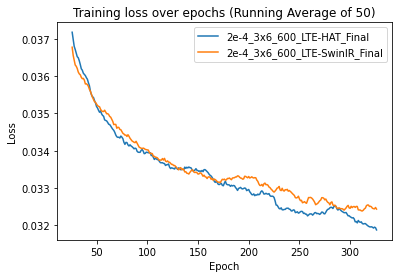

In [41]:
def running_average(x, y, N):
    y_ = np.convolve(y, np.ones(N)/N, mode='valid')
    x_ = x[N//2:-N//2+1]
    return x_, y_


log_directories = [
                        # '1e-4_4x6_300_LTE-SwinIR',
                        # '2e-4_2x6_600_LTE-SwinIR', 
                        # '2e-4_2x6_900_LTE-SwinIR', 
                        # '2e-4_6x2_900_LTE-SwinIR',
                        # '2e-4_6x6_300_LTE-SwinIR',
                        # '5e-5_4x6_300_LTE-SwinIR', 
                        '2e-4_3x6_600_LTE-HAT_Final',
                        '2e-4_3x6_600_LTE-SwinIR_Final'
                  ]

all_losses = []
for log in log_directories:
    descriptor = log                                    # The name of the folder is the descriptor
    log_file = open(os.path.join('Training Trials', log, 'log.txt'), "r")              # Open log.txt
    log = log_file.readlines()
    losses_over_epochs = []
    epochs = []                                         
    psnrs = []
    epoch_counter = 1
    for line in log:                                    # Iterate over the lines in log.txt
        if line[0] == 'e':                              # Lines that start with e are the appropriate ones
            loss = float(line.split()[3][5:11])         # When spit, 3 is loss=######, 5:11 gives the ####, and then we convert to float
            losses_over_epochs.append(loss)
            epochs.append(epoch_counter)
            epoch_counter += 1

    log_file.close()                                    # Close the file when done reading it
    all_losses.append((descriptor, epochs, losses_over_epochs))

# Loss plot
N = 50
for descriptor, epochs, losses_over_epochs in all_losses:
    # plt.plot(epochs, losses_over_epochs, label=descriptor)    # Raw data
    epoch_average, loss_average = running_average(epochs, losses_over_epochs, N)
    plt.plot(epoch_average, loss_average, label=str(descriptor))
plt.title('Training loss over epochs (Running Average of %d)' % N)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
